In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import equinox as eqx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os 
from scipy.special import j1
import dLux.utils as dlu

In [2]:
emnist=jnp.load("/fred/oz440/jonah/data/emnist.npz",allow_pickle=True)
data=emnist["x_test"].astype("float32")/255.
labels=emnist["y_test"]
randKey=jax.random.PRNGKey(12)
idx_10=jax.random.randint(randKey,(10,),0,len(labels))
data_10=data[idx_10,:]
labels_10=labels[idx_10]

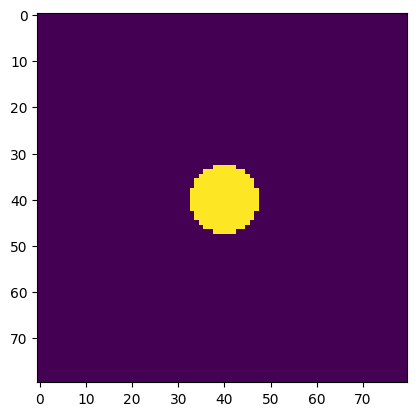

In [3]:
pscale=66/10
wavel=4.3e-6
mas2rad=jnp.pi/180./3600./1000.
x=jnp.arange(80)*pscale-80*pscale/2
y=x.copy()
xx,yy=jnp.meshgrid(x,y)
max_baseline=50
baseline_samples=64
u,v=jnp.linspace(-max_baseline,max_baseline,baseline_samples),jnp.linspace(-max_baseline,max_baseline,baseline_samples)
uu,vv=jnp.meshgrid(u,v)
uvgrid=jnp.vstack((uu.flatten(),vv.flatten())).T
rr=jnp.sqrt(xx**2+yy**2)
circular_star=1.0*(rr<50)
plt.imshow(circular_star)

In [ ]:
def compute_DFTM2(in_coords,out_coords,inverse,axis=0):
    in2out=jnp.outer(in_coords,out_coords)
    if inverse==True:
        in2out*=-1
    ftm=jnp.exp(2.*jnp.pi*1j*in2out)

    if axis !=0:
        return ftm
    else:
        return ftm.T

def both_DFTM2(u,v,img_size,wavel,pscale,inverse):
    out_coords=u/wavel
    in_coords=(jnp.arange(img_size)-img_size/2)*pscale*mas2rad
    LL=compute_DFTM2(in_coords,out_coords,axis=0,inverse=inverse)

    out_coords=v/wavel
    RR=compute_DFTM2(in_coords,out_coords,axis=1,inverse=inverse)
    
    return LL,RR

def apply_DFTM2(image,u,v,pscale,wavel,inverse=False):
    image /=jnp.sum(image)
    img_size=image.shape[0]
    LL,RR=both_DFTM2(u,v,img_size,wavel,pscale,inverse)
    LL_shift=jnp.vmap()

    FT=jnp.dot(LL,jnp.dot(image,RR))
    return FT
    

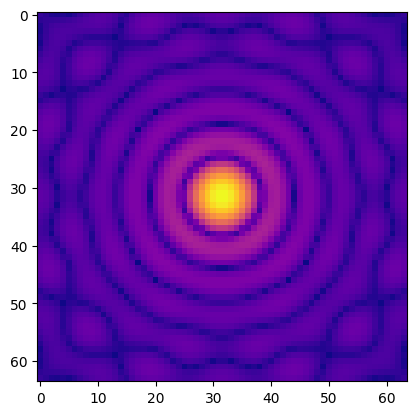

In [5]:
two_sided=apply_DFTM2(circular_star,u,v,pscale,wavel)
v2_two,phase_two=jnp.abs(two_sided)**2,jnp.angle(two_sided)
plt.imshow(v2_two**.25,cmap="plasma")


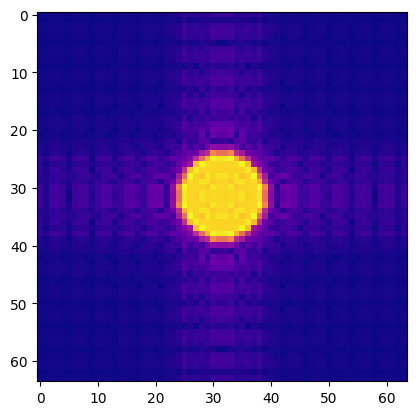

In [ ]:
inverse_img=apply_DFTM2(two_sided,u,v,pscale,wavel,inverse=True)

inv_v2_two,inv_phase_two=jnp.abs(inverse_img)**2,jnp.angle(inverse_img)
plt.imshow(inv_v2_two**.25)
plt.plasma()

In [144]:
jnp.zeros(3)

Array([0., 0., 0.], dtype=float32)

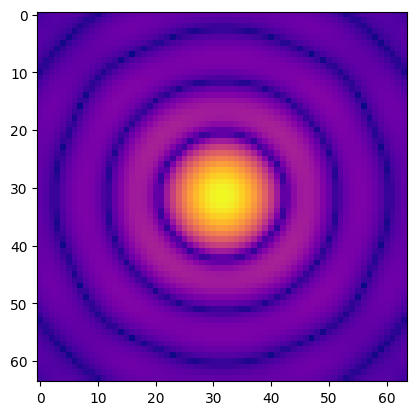

In [ ]:
dlu_2s=dlu.MFT(phasor=circular_star,wavelength=wavel,pixel_scale_in=1,npixels_out=64,pixel_scale_out=pscale*mas2rad,shift=jnp.zeros(2))
dlu_2s_two,dlu_phase_two=jnp.abs(dlu_2s)**2,jnp.angle(dlu_2s)
plt.imshow(dlu_2s_two**.25)
plt.plasma()

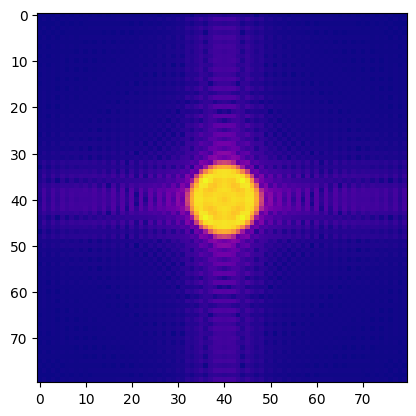

In [127]:
inv_dlu_2s=dlu.MFT(phasor=dlu_2s,wavelength=wavel,pixel_scale_in=pscale*mas2rad,npixels_out=80,pixel_scale_out=1,inverse=True)
inv_dlu_2s_two,inv_dlu_phase_two=jnp.abs(inv_dlu_2s)**2,jnp.angle(inv_dlu_2s)
plt.imshow(inv_dlu_2s_two**.25)
plt.plasma()

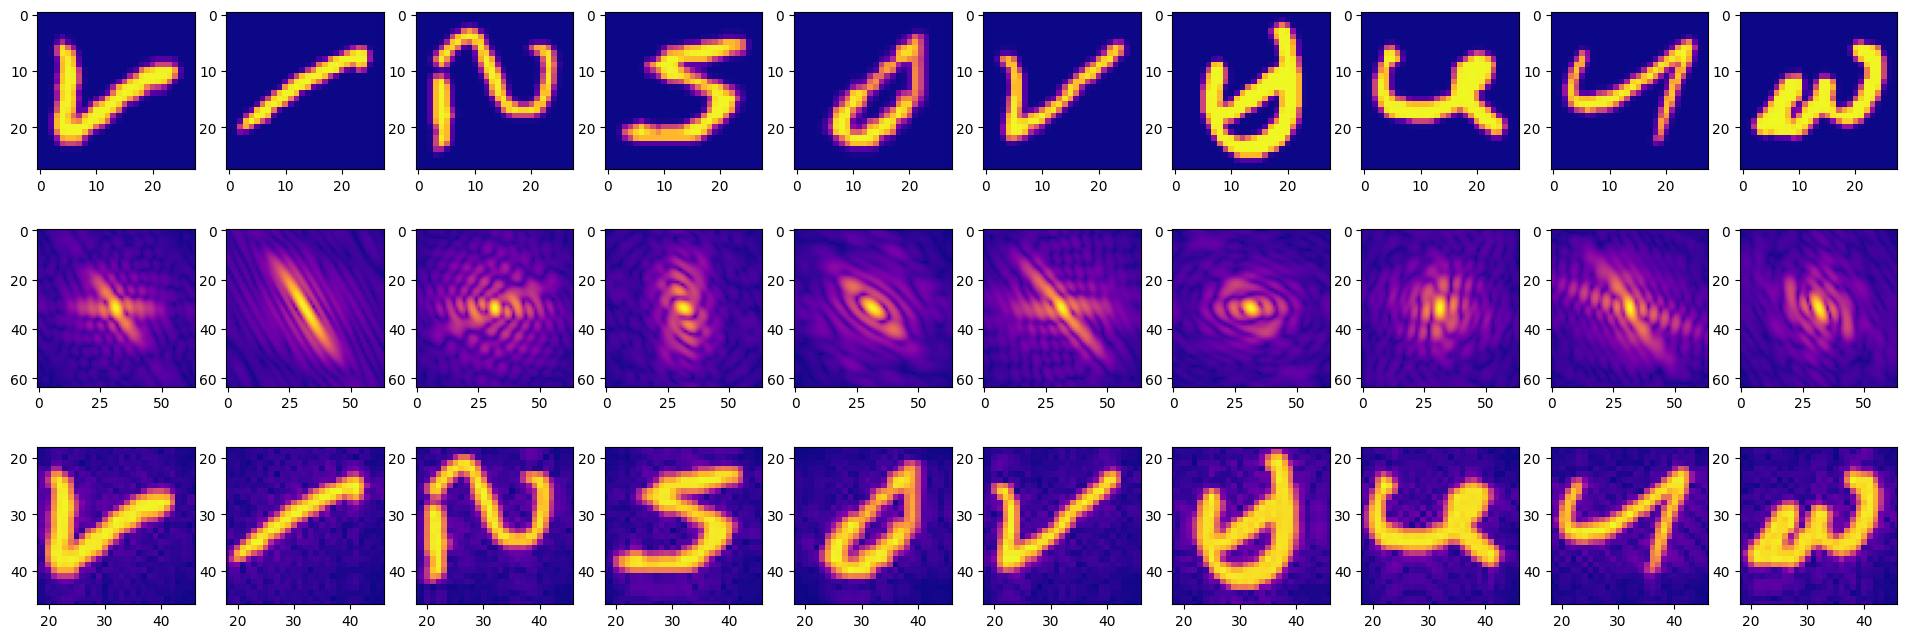

In [19]:
n=10
plt.figure(figsize=(24,8))
for i, image in enumerate(data_10):
    
    two_sided=apply_DFTM2(image,u,v,pscale,wavel)
    v2_two,phase_two=jnp.abs(two_sided)**2,jnp.angle(two_sided)

    inverse_img=apply_DFTM2(two_sided,u,v,pscale,wavel,inverse=True)
    inv_v2_two,inv_phase_two=jnp.abs(inverse_img)**2,jnp.angle(inverse_img)

    ax=plt.subplot(3,n,i+1)
    plt.imshow(image)
    plt.plasma()
    # ax.axis("off")

    ax=plt.subplot(3,n,i+1+n)
    plt.imshow(v2_two**.25)
    plt.plasma()
    # ax.axis("off")

    ax=plt.subplot(3,n,i+1+2*n)
    plt.imshow(inv_v2_two**.25)
    plt.xlim(baseline_samples/2-14,baseline_samples/2+14)
    plt.ylim(baseline_samples/2+14,baseline_samples/2-14)
    plt.plasma()
    # ax.axis("off")

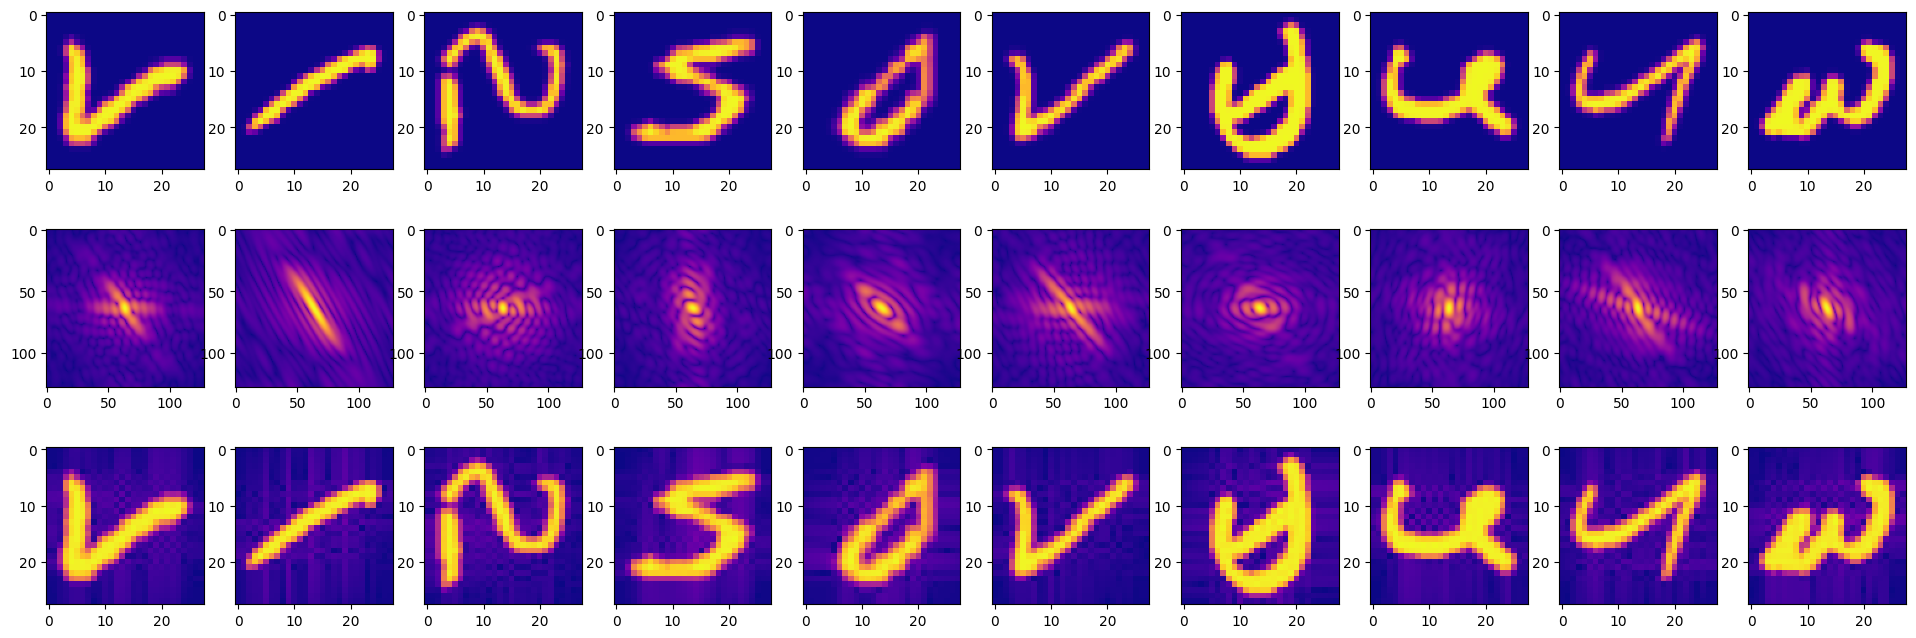

In [ ]:
n=10
plt.figure(figsize=(24,8))
for i, image in enumerate(data_10):
    
    two_sided=dlu.MFT(phasor=image,wavelength=wavel,pixel_scale_in=1,npixels_out=128,pixel_scale_out=pscale*mas2rad)
    v2_two,phase_two=jnp.abs(two_sided)**2,jnp.angle(two_sided)

    inv_img=dlu.MFT(phasor=two_sided,wavelength=wavel,pixel_scale_in=pscale*mas2rad,npixels_out=28,pixel_scale_out=1,inverse=True)
    inv_v2_two,inv_v2_phase=jnp.abs(inv_img)**2,jnp.angle(inv_img)

    residuals=two_sided-inv_img

    ax=plt.subplot(3,n,i+1)
    plt.imshow(image)
    plt.plasma()
    # ax.axis("off")

    ax=plt.subplot(3,n,i+1+n)
    plt.imshow((v2_two**.25))
    plt.plasma()
    # ax.axis("off")

    ax=plt.subplot(3,n,i+1+2*n)
    plt.imshow(inv_v2_two**.25)
    # plt.xlim(baseline_samples/2-14,baseline_samples/2+14)
    # plt.ylim(baseline_samples/2+14,baseline_samples/2-14)
    plt.plasma()
    # ax.axis("off")

In [ ]:
inv_dlu_2s=dlu.MFT(phasor=dlu_2s,wavelength=wavel,pixel_scale_in=pscale*mas2rad,npixels_out=80,pixel_scale_out=1,inverse=True)
inv_dlu_2s_two,inv_dlu_phase_two=jnp.abs(inv_dlu_2s)**2,jnp.angle(inv_dlu_2s)
plt.imshow(inv_dlu_2s_two**.25)
plt.plasma()

In [124]:
jnp.zeros(0)

Array([], shape=(0,), dtype=float32)